In [1]:
# This is the import cell
import sys
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
first = True
pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", 10)

# Here are my rc parameters for matplotlib
mpl.rc('font', serif='Helvetica Neue') 
mpl.rcParams.update({'font.size': 12})
mpl.rcParams['figure.figsize'] = 3.2, 2.8
mpl.rcParams['figure.dpi'] = 1000
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['lines.linewidth'] = 0.5
mpl.rcParams['axes.linewidth'] = 1.5

In [2]:
# Get the current path
if first:
    parent = os.getcwd()
os.chdir(parent)

# Grab file names from data folder
data = os.listdir('densityData')
try:
    data.remove('.DS_Store')
except:
    print(".DS_Store not in directory")
print(data)

.DS_Store not in directory
['phase_density_pa10_pb20_xa50.txt', 'phase_density_pa125_pb500_xa10.txt', 'phase_density_pa60_pb120_xa30.txt', 'phase_density_pa130_pb260_xa70.txt', 'phase_density_pa250_pb500_xa90.txt', 'phase_density_pa140_pb155_xa50.txt', 'phase_density_pa80_pb266_xa50.txt', 'phase_density_pa120_pb171_xa50.txt', 'phase_density_pa375_pb500_xa60.txt', 'phase_density_pa150_pb500_xa70.txt', 'phase_density_pa500_pb500_xa50.txt', 'phase_density_pa350_pb500_xa30.txt', 'phase_density_pa110_pb366_xa70.txt', 'phase_density_pa120_pb400_xa30.txt', 'phase_density_pa100_pb500_xa40.txt', 'phase_density_pa140_pb200_xa70.txt', 'phase_density_pa110_pb157_xa30.txt', 'phase_density_pa50_pb500_xa60.txt', 'phase_density_pa200_pb500_xa60.txt', 'phase_density_pa400_pb500_xa30.txt', 'phase_density_pa250_pb500_xa50.txt', 'phase_density_pa130_pb433_xa30.txt', 'phase_density_pa120_pb133_xa50.txt', 'phase_density_pa70_pb140_xa50.txt', 'phase_density_pa40_pb80_xa50.txt', 'phase_density_pa500_pb500_xa9

In [3]:
# Some functions to get the relevant data from the filenames
def checkFile(fname, string):
    for i in xrange(len(fname)):
        if fname[i] == string[0]:
#             print"{} matches {}".format(fname[i], string[0])
            for j in xrange(1, len(string)):
                if fname[i + j] == string[j]:
#                     print"{} matches {}".format(fname[i+j], string[j])
                    if j == (len(string) - 1):
#                         print"Final match!"
                        return True
                else:
                    break
    return False
    
def txtValue(fname, string):
    out = ""
    index = 0
    for i in xrange(len(fname)):
        if fname[i] == string[0]:
            for j in xrange(1, len(string)):
                if fname[i + j] == string[j]:
                    if j == (len(string) - 1):
                        # Last index of search string
                        index = i + j
                else:
                    break
                        
    # First index of value
    index += 1
    mybool = True
    while mybool:
        if fname[index].isdigit():
            out = out + fname[index]
            index += 1
        elif fname[index] == ".":    
            if fname[index+1].isdigit():
                out = out + fname[index]
                index += 1
            else:
                mybool = False
        else:
            mybool = False
    return float(out)

# Sorting functions
def multiSort(arr1, arr2, arr3):
    """Sort an array the slow (but certain) way, returns original indices in sorted order"""
    # Doing this for PeR, PeS, xS in this case
    cpy1 = np.copy(arr1)
    cpy2 = np.copy(arr2)
    cpy3 = np.copy(arr3)
    ind = np.arange(0, len(arr1))
    for i in xrange(len(cpy1)):
        for j in xrange(len(cpy1)):
            # Sort by first variable
            if cpy1[i] > cpy1[j] and i < j:
                # Swap copy array values
                cpy1[i], cpy1[j] = cpy1[j], cpy1[i]
                cpy2[i], cpy2[j] = cpy2[j], cpy2[i]
                cpy3[i], cpy3[j] = cpy3[j], cpy3[i]
                # Swap the corresponding indices
                ind[i], ind[j] = ind[j], ind[i]
                
            # If first variable is equal, resort to second variable
            elif cpy1[i] == cpy1[j] and cpy2[i] > cpy2[j] and i < j:
                # Swap copy array values
                cpy1[i], cpy1[j] = cpy1[j], cpy1[i]
                cpy2[i], cpy2[j] = cpy2[j], cpy2[i]
                cpy3[i], cpy3[j] = cpy3[j], cpy3[i]
                # Swap the corresponding indices
                ind[i], ind[j] = ind[j], ind[i]
                
            elif cpy1[i] == cpy1[j] and cpy2[i] == cpy2[j] and cpy3[i] > cpy3[j] and i < j:
                # Swap copy array values
                cpy1[i], cpy1[j] = cpy1[j], cpy1[i]
                cpy2[i], cpy2[j] = cpy2[j], cpy2[i]
                cpy3[i], cpy3[j] = cpy3[j], cpy3[i]
                # Swap the corresponding indices
                ind[i], ind[j] = ind[j], ind[i]      
    return ind

def indSort(arr1, arr2):
    """Take sorted index array, use to sort array"""
    # arr1 is array to sort
    # arr2 is index array
    cpy = np.copy(arr1)
    for i in xrange(len(arr1)):
        arr1[i] = cpy[arr2[i]]

In [4]:
# Grab parameters, sort them
def computePeNet(PeS, PeF, xF):
    # Make sure particle fraction is in appropriate range
    if xF > 1.:
        xF /= 100.
    # Make sure slow species is actually slower
    if PeS > PeF:
        PeS, PeF = PeF, PeS
        xF = 1. - xF
    peNet = ((1. - xF) * PeS) + (xF * PeF)
    peRNet = (((1. - xF)*(np.sqrt(PeS/PeF))) + xF) * peNet
    return peNet, peRNet

peList = []
paList = []
pbList = []
xaList = []
epList = []
phiList = []
peNetList = []
peRNetList = []
for i in xrange(len(data)):
    if checkFile(data[i], "pe"):
        peList.append(txtValue(data[i], "pe"))
    else:
        peList.append(0)
    
    if checkFile(data[i], "pa"):
        paList.append(txtValue(data[i], "pa"))
    else:
        paList.append(0)
        
    if checkFile(data[i], "pb"):
        pbList.append(txtValue(data[i], "pb"))
    else:
        pbList.append(0)
        
    if checkFile(data[i], "xa"):
        xaList.append(txtValue(data[i], "xa"))
    else:
        xaList.append(100.)
        
    if checkFile(data[i], "ep"):
        epList.append(txtValue(data[i], "ep"))
    else:
        epList.append(1.)
        
    if checkFile(data[i], "phi"):
        phiList.append(txtValue(data[i], "phi"))
    else:
        phiList.append(60.)
    
    peNet, peRNet = computePeNet(paList[-1], pbList[-1], 100. - xaList[-1])
    peNetList.append(peNet)
    peRNetList.append(peRNet)

# Take a look at your lists
# print(peList)
# print(paList) 
# print(pbList) 
# print(xaList) 
# print(epList) 
# print(phiList)        

# Sort the arrays
if len(paList) > 1:
    # Sort them!
    print("Sorting... ")
    indArr = multiSort(peNetList, paList, pbList)
    indSort(data, indArr)
    indSort(peList, indArr)
    indSort(paList, indArr)
    indSort(pbList, indArr)
    indSort(xaList, indArr)
    indSort(epList, indArr)
    indSort(phiList, indArr)
    indSort(peNetList, indArr)
    indSort(peRNetList, indArr)

# Print the sorted array
print("Sorted textfiles:")
for i in data:
    print(i)
    
# Now that the data is sorted, read it into a dataframe
all_data = []
os.chdir('densityData')
for i in xrange(len(data)):
    df = pd.read_csv(data[i], sep='\s+', header=0)
    all_data.append(df)
os.chdir(parent)

# This is how you access the data at different levels
display(all_data[0])
# print(all_data[0]['Timestep'])
# print(all_data[0]['Timestep'][0])

Sorting... 
Sorted textfiles:
phase_density_pa10_pb11_xa50.txt
phase_density_pa10_pb14_xa70.txt
phase_density_pa10_pb14_xa50.txt
phase_density_pa10_pb14_xa30.txt
phase_density_pa10_pb20_xa70.txt
phase_density_pa10_pb20_xa50.txt
phase_density_pa10_pb33_xa70.txt
phase_density_pa10_pb20_xa30.txt
phase_density_pa20_pb22_xa50.txt
phase_density_pa10_pb33_xa50.txt
phase_density_pa20_pb28_xa70.txt
phase_density_pa20_pb28_xa50.txt
phase_density_pa20_pb28_xa30.txt
phase_density_pa20_pb40_xa70.txt
phase_density_pa10_pb33_xa30.txt
phase_density_pa20_pb40_xa50.txt
phase_density_pa30_pb33_xa50.txt
phase_density_pa30_pb42_xa70.txt
phase_density_pa20_pb66_xa70.txt
phase_density_pa20_pb40_xa30.txt
phase_density_pa30_pb42_xa50.txt
phase_density_pa30_pb42_xa30.txt
phase_density_pa30_pb60_xa70.txt
phase_density_pa40_pb44_xa50.txt
phase_density_pa20_pb66_xa50.txt
phase_density_pa30_pb60_xa50.txt
phase_density_pa40_pb57_xa70.txt
phase_density_pa40_pb57_xa50.txt
phase_density_pa0_pb500_xa90.txt
phase_density

,Timestep,Gas-r=1.0,Liq-r=1.0,Gas-r=2.0,Liq-r=2.0,Gas-r=3.0,Liq-r=3.0,Gas-r=3.5,Liq-r=3.5,Gas-r=4.0,Liq-r=4.0,Gas-r=4.5,Liq-r=4.5,Gas-r=5.0,Liq-r=5.0
0,49.0,0.25,0.75,0.56,0.625,0.58,0.61,0.59,0.63,0.59,0.625,0.59,0.615,0.565,0.61
1,49.5,0.25,0.75,0.56,0.625,0.58,0.61,0.59,0.63,0.59,0.605,0.59,0.615,0.565,0.61


In [5]:
# Function to get conversion from timesteps to Brownian time
def computeTauPerTstep(epsilon, mindt=0.00001):
    if epsilon == 1.:
        mindt = 0.000001
    kBT = 1.0
    tstepPerTau = int(epsilon / (kBT * mindt))
    return 1. / tstepPerTau

# Grab the parameters from each file, store in a dataframe
headers = ['pe', 'peA', 'peB', 'xA', 'peR', 'peNet', 'peRNet', 'eps', 'phi', 'tauPer_dt']
params = pd.DataFrame(columns=headers)
for i in xrange(len(all_data)):
    pe = int(peList[i])
    pa = int(paList[i])
    pb = int(pbList[i])
    xa = float(xaList[i])
    if xa != 0 and xa != 100:
        if pa > pb:
            peR = float(pb) / float(pa)
        else:
            peR = float(pa) / float(pb)
    else:
        peR = 1.
    peNet = float(peNetList[i])
    peRNet = float(peRNetList[i])
    ep = int(epList[i])
    phi = float(phiList[i])
    if ep == 1:
        tauPerdt = computeTauPerTstep(ep, 0.000001)
    else:
        tauPerdt = computeTauPerTstep(ep)
    df = pd.DataFrame([[pe, pa, pb, xa, peR, peNet, peRNet, ep, phi, tauPerdt]], columns=headers)
    params = params.append(df, ignore_index = True)
display(params)

,pe,peA,peB,xA,peR,peNet,peRNet,eps,phi,tauPer_dt
0,0,10,11,50.0,0.909091,10.5,10.255679,1,60.0,0.000001
1,0,10,14,70.0,0.714286,11.2,9.986009,1,60.0,0.000001
2,0,10,14,50.0,0.714286,12.0,11.070926,1,60.0,0.000001
3,0,10,14,30.0,0.714286,12.8,12.205392,1,60.0,0.000001
4,0,10,20,70.0,0.500000,13.0,10.334672,1,60.0,0.000001
...,...,...,...,...,...,...,...,...,...,...
254,0,110,1100,50.0,0.100000,605.0,398.158899,1,60.0,0.000001
255,0,120,1200,50.0,0.100000,660.0,434.355163,1,60.0,0.000001
256,0,130,1300,50.0,0.100000,715.0,470.551426,1,60.0,0.000001
257,0,140,1400,50.0,0.100000,770.0,506.747690,1,60.0,0.000001


In [6]:
# Let's add columns to the time-resolved simulation data
for i in xrange(len(all_data)):
    # Ger rid of NaN in favor of 0
    all_data[i].fillna(0, inplace=True)

# display(all_data[0][0])
display(all_data[0])

,Timestep,Gas-r=1.0,Liq-r=1.0,Gas-r=2.0,Liq-r=2.0,Gas-r=3.0,Liq-r=3.0,Gas-r=3.5,Liq-r=3.5,Gas-r=4.0,Liq-r=4.0,Gas-r=4.5,Liq-r=4.5,Gas-r=5.0,Liq-r=5.0
0,49.0,0.25,0.75,0.56,0.625,0.58,0.61,0.59,0.63,0.59,0.625,0.59,0.615,0.565,0.61
1,49.5,0.25,0.75,0.56,0.625,0.58,0.61,0.59,0.63,0.59,0.605,0.59,0.615,0.565,0.61


In [7]:
%%capture
# Plot each column vs time for all files
for z in list(all_data[0]):
    for i in xrange(len(all_data)):
        plt.plot(all_data[i]['Timestep'], all_data[i][z], c=plt.cm.jet(params['peNet'][i] / max(params['peNet'])), label=(params['pe'][i]))
    plt.xlabel(r'Time $(\tau_{r})$')
    plt.ylabel(z)
    plt.title(z)
#     plt.legend()
    plt.show()

Totals
A activity: 30
B activity: 60
A fraction: 30.0
A activity: 40
B activity: 57
A fraction: 30.0
A activity: 50
B activity: 55
A fraction: 50.0
A activity: 50
B activity: 71
A fraction: 70.0


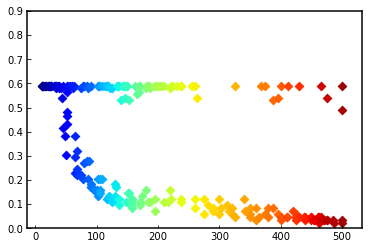

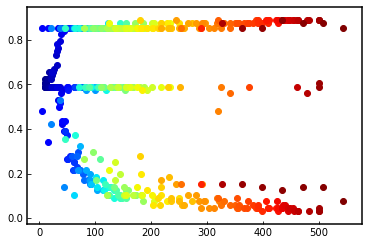

In [10]:
# Let's try and plot phiG and phiC vs peNet
print("Totals")

flag = 0
for i in xrange(len(all_data)):
    if params['peR'][i] > 0.1:
        plt.scatter(params['peNet'][i], all_data[i]['Gas-r=4.5'][0], c=plt.cm.jet(float(i)/len(all_data)), marker='D')
#         plt.scatter(params['peNet'][i], all_data[i]['Liq-r=4.5'][0], c=plt.cm.jet(float(i)/len(all_data)), marker='D')
    if all_data[i]['Gas-r=4.5'][0] > 0.5 and 50. < params['peNet'][i] < 60.:
        print("A activity: {}").format(params['peA'][i])
        print("B activity: {}").format(params['peB'][i])
        print("A fraction: {}").format(params['xA'][i])
#     if ssAvg['phiG'][i] <= ssAvg['phiC'][i] and flag == 0:
#         peNCrit = params['peNet'][i]
#         flag = 1
# plt.axvline(x=peNCrit, ls='--', lw=2.5, c='k')
plt.ylim(0.0, 0.9)
plt.show()

flag = 0
for i in xrange(len(all_data)):
    if params['peR'][i] > -0.1:
        plt.scatter(params['peRNet'][i], all_data[i]['Gas-r=4.0'][0], c=plt.cm.jet(float(i)/len(all_data)))
        plt.scatter(params['peRNet'][i], all_data[i]['Liq-r=4.0'][0], c=plt.cm.jet(float(i)/len(all_data)))
#     if ssAvg['phiG'][i] <= ssAvg['phiC'][i] and flag == 0:
#         peNRCrit = params['peRNet'][i]
#         flag = 1
# plt.axvline(x=peNRCrit, ls='--', lw=2.5, c='k')
plt.show()

In [9]:
# Let's grab a fit for the loglog m vs fractional inverse pe plot
def plotLine(x, m, b):
    return (m*x) + b

def plotPow(x, m, b):
    return (x**m)*(np.exp(b))

def getRSquared(xdat, ydat, m, b):
    # Compute the average y value
    avg = np.mean(ydat)
    real = 0.0
    pred = 0.0
    # Get the distance from real and predicted values to mean
    for i in xrange(len(ydat)):
        real += (ydat[i] - avg)**2
        pred += (plotLine(xdat[i], m, b) - avg)**2
    return pred / real

peNCritInv = 1. / peNCrit
logtau = []
logm = []
pers = []
for i in xrange(len(all_data)):
    if params['peR'][i] > 0.1:
        x = np.log(-1.*(1./params['peNet'][i] - peNCritInv)/peNCritInv)
        y = np.log((ssAvg['phiC'][i] - ssAvg['phiG'][i])/0.6)
        if not np.isnan(x) and not np.isnan(y):
            if not np.isinf(x) and not np.isinf(y):
                if not np.isinf(-x) and not np.isinf(-y):
                    logtau.append(x)
                    logm.append(y)
                    pers.append(params['peR'][i])

rangeDat = np.arange(np.log(10**-2), np.log(10.), 0.001)        
m, b = np.polyfit(logtau, logm, 1)
res = getRSquared(logtau, logm, 3./4., b)
print(res)
print(m)
print(b)
plt.plot(rangeDat, plotLine(rangeDat, 3./4., b))
plt.scatter(logtau, logm, c=pers, cmap=mpl.cm.jet)
plt.xlim(-3, 0)



NameError: name 'peNCrit' is not defined

In [ ]:
# Make a nicer looking figure for the binodal
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.lines import Line2D

fig, ax = plt.subplots(2, 1, figsize=(5, 8))
for i in xrange(len(all_data)):
    if params['peR'][i] > 0.1:
#     if params['peR'][i] > 0.1 and params['peNet'][i] >= peNCrit:
        ax[0].scatter(params['peNet'][i], ssAvg['phiG'][i], c=plt.cm.jet(params['peR'][i]), marker='D')
        ax[0].scatter(params['peNet'][i], ssAvg['phiC'][i], c=plt.cm.jet(params['peR'][i]), marker='o')

ax[0].set_xlabel(r'Net activity $(Pe_{net})$')
ax[0].set_ylabel(r'Area fraction')
ax[0].set_xlim(0, 500)
ax[0].set_ylim(-0.02, 0.62)

# Set tick dims
ax[0].xaxis.set_major_locator(MultipleLocator(100))
ax[0].xaxis.set_minor_locator(MultipleLocator(25))
ax[0].yaxis.set_major_locator(MultipleLocator(0.1))
ax[0].yaxis.set_minor_locator(MultipleLocator(0.05))
ax[0].tick_params(which='major', length=6, width = 1.5)
ax[0].tick_params(which='minor', length=4.5, width = 1.5)

# Make a shape legend
leg = [Line2D([0], [0], marker='o', color='w', linestyle='', label='Liquid', markerfacecolor='k', markersize=7),
       Line2D([0], [0], marker='D', color='w', linestyle='', label='Gas', markerfacecolor='k', markersize=7)]
ax[0].legend(handles=leg, loc = 2, title=r'Phase',
          bbox_to_anchor=(0.775, 0.67), bbox_transform=ax[0].transAxes,
          frameon=False,
          handletextpad=-0.1)

# Make a colorbar (left, bottom, width, height)
ax2 = fig.add_axes([0.55, 0.78, 0.32, 0.0175])
cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=0.0, vmax=1.0)
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=mpl.cm.jet,
                                norm=norm,
                                orientation='horizontal',
                               ticks=[0.0, 0.5, 1.0])
cb1.set_label(r'$Pe_{R}$', labelpad=-40, rotation=0)

# Plot the order parameter here
for i in xrange(len(all_data)):
    if params['peR'][i] > 0.1:
        ax[1].scatter((1./params['peNet'][i]), (ssAvg['phiC'][i] - ssAvg['phiG'][i])/0.6, 
                      c=plt.cm.jet(params['peR'][i]), marker='s')
ax[1].set_xlabel(r'Inverse net activity $\left(\frac{1}{Pe_{net}}\right)$', fontsize=14)
ax[1].set_ylabel(r'Order parameter $\left(m=\frac{\phi_{l}-\phi_{g}}{\phi}\right)$')
ax[1].set_xlim(1./1000., 0.05)
ax[1].set_ylim(-1., 1.)
ax[1].xaxis.set_ticks([1./1000., 10./1000., 20./1000., 30./1000., 40./1000., 50./1000.])
ax[1].set_xticklabels([r'$\frac{1}{1000}$',
                       r'$\frac{1}{100}$',
                       r'$\frac{1}{50}$',
                       r'$\frac{1}{33}$',
                       r'$\frac{1}{25}$',
                       r'$\frac{1}{20}$'])

# Set tick dims
# ax[1].xaxis.set_major_locator(MultipleLocator(100))
ax[1].xaxis.set_minor_locator(MultipleLocator(0.005))
ax[1].yaxis.set_major_locator(MultipleLocator(0.5))
ax[1].yaxis.set_minor_locator(MultipleLocator(0.1))
ax[1].tick_params(which='major', length=6, width = 1.5)
ax[1].tick_params(which='minor', length=4.5, width = 1.5)
# Horizontal line at m=0
ax[1].axhline(y=0, lw=1.5, ls='--', c='k', zorder=0)

# Inset to bottom plot
left, bottom, width, height = [0.59, 0.245, 0.28, 0.20]
ax3 = fig.add_axes([left, bottom, width, height])
peNCritInv = 1. / peNCrit
for i in xrange(len(all_data)):
    if params['peR'][i] > 0.1:
        ax3.scatter( ((1./params['peNet'][i] - peNCritInv)/peNCritInv)*-1 , (ssAvg['phiC'][i] - ssAvg['phiG'][i])/0.6, 
                    c=plt.cm.jet(params['peR'][i]), marker='s')

expRange = np.arange(0.0001, 10., 0.0001)  
ax3.plot(expRange, plotPow(expRange, 3./4., b), lw=1.5, ls='--', c='k', zorder=0)
ax3.text(0.67, 0.31, r'$\frac{3}{4}$', 
         horizontalalignment='center', verticalalignment='center', transform=ax3.transAxes,
         fontsize=14)
# Plot triangle for slope
leftx = 0.15
rightx = 0.35
boty = plotPow(leftx, 3./4., (b*-5.))
topy = plotPow(rightx, 3./4., (b*-5.))
plt.plot([leftx, rightx, rightx, leftx], [boty, topy, boty, boty], zorder=0, c='k', ls='-', lw=1.5)

# Limits, labels, ticks
ax3.set_xlim(0.05, 1.2)
ax3.set_ylim(0.06, 1.2)
# ax3.set_xlabel(r'$\frac{-\left(Pe_{net}^{-1}-Pe_{net,c}^{-1}\right)}{Pe_{net,c}^{-1}}$')
ax3.set_xlabel(r'$\tau$', labelpad=-5)
ax3.set_ylabel(r'$m$', labelpad=-8)
ax3.loglog()
ax3.tick_params(which='major', length=6, width = 1.5)
ax3.tick_params(which='minor', length=4.5, width = 1.5)

# Add letter labels to figure
ax[0].text(-0.15, 0.97, r'(a)', 
           horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes,
           fontsize=14)
ax[1].text(-0.15, 0.97, r'(b)', 
           horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes,
           fontsize=14)

plt.savefig('net_activity_binodal.pdf', dpi=1000, bbox_inches = 'tight', pad_inches = 0.01)

In [ ]:
# Plot the order parameter here
for i in xrange(len(all_data)):
    if params['peR'][i] > 0.1:
        plt.scatter((1./params['peNet'][i]), (ssAvg['phiC'][i] - ssAvg['phiG'][i])/0.6, c=plt.cm.jet(params['peR'][i]))
plt.xlabel(r'$\frac{1}{Pe_{net}}$', fontsize=14)
plt.ylabel(r'$\left(\frac{\phi_{l}-\phi_{g}}{\phi_{A}}\right)$')
plt.xlim(right=0.04)
plt.ylim()
plt.show()

In [ ]:
# # Let's try and plot phiG and phiC vs peNet
# for i in xrange(len(all_data)):
#     plt.scatter(params['peNet'][i], ssAvg['rhoG'][i])
#     plt.scatter(params['peNet'][i], ssAvg['rhoC'][i])
# plt.show()
    
# for i in xrange(len(all_data)):
#     plt.scatter(params['peRNet'][i], ssAvg['rhoG'][i])
#     plt.scatter(params['peRNet'][i], ssAvg['rhoC'][i])
# plt.show()

In [ ]:
# Show that the order parameter goes from -1 to 1
for i in xrange(len(all_data)):
    if params['peR'][i] > 0.1:
        plt.scatter((1./params['peNet'][i]), (ssAvg['phiC'][i] - ssAvg['phiG'][i])/0.6, c=plt.cm.jet(params['peR'][i]))
plt.xlabel(r'$\frac{1}{Pe_{net}}$', fontsize=14)
plt.ylabel(r'$\phi_{l}-\phi_{g}$')
plt.xlim(right=0.03)
plt.ylim(bottom=0)
plt.show()

for i in xrange(len(all_data)):
    if params['peR'][i] > 0.1:
        plt.scatter((1./params['peRNet'][i]), (ssAvg['phiC'][i] - ssAvg['phiG'][i])/0.6, c=plt.cm.jet(params['peR'][i]))
plt.xlabel(r'$\frac{1}{Pe_{net}^{R}}$', fontsize=14)
plt.ylabel(r'$\phi_{l}-\phi_{g}$')
plt.xlim(right=0.03)
plt.ylim(bottom=0)
plt.show()

In [ ]:
# Let's look at the difference in densities... just like boiling water!

# We look at the plot and say Pe_c ~ 50
# peNCrit = 50.
for i in xrange(len(all_data)):
    if params['peR'][i] > 0.1:
        plt.scatter((params['peNet'][i] - peNCrit) / peNCrit, (ssAvg['phiC'][i] / 0.6) - (ssAvg['phiG'][i] / 0.6), c=plt.cm.jet(params['peR'][i]))
plt.xlabel(r'$\frac{T-T_{c}}{T_{c}}$')
plt.ylabel(r'$\phi_{l}-\phi_{g}$')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(bottom=10**-2)
plt.show()

In [ ]:
# Let's get a fit for this to get our critical exponent

# Function for basic line
def plotLine(x, m, b):
    return (m*x) + b

def plotPow(x, m, b):
    return (x**m)*(np.exp(b))

def getRSquared(xdat, ydat, m, b):
    # Compute the average y value
    avg = np.mean(ydat)
    real = 0.0
    pred = 0.0
    # Get the distance from real and predicted values to mean
    for i in xrange(len(ydat)):
        real += (ydat[i] - avg)**2
        pred += (plotLine(xdat[i], m, b) - avg)**2
    return pred / real

# Get the data to fit
xfit = []
yfit = []
logFracDevPe = []
logPhiDiff = []
for i in xrange(len(all_data)):
    if params['peR'][i] > 0.1:
        logx = np.log((params['peNet'][i] - peNCrit) / peNCrit)
        logy = np.log((ssAvg['phiC'][i] / 0.6) - (ssAvg['phiG'][i] / 0.6))
        if not math.isnan(logx) and not math.isnan(logy):
            if not math.isinf(logx) and not math.isinf(logy):
                xfit.append((params['peNet'][i] - peNCrit) / peNCrit)
                yfit.append((ssAvg['phiC'][i] / 0.6) - (ssAvg['phiG'][i] / 0.6))
                logFracDevPe.append(logx)
                logPhiDiff.append(logy)

rangeDat = np.arange(np.log(10**-2), np.log(10.), 0.000001)        
m, b = np.polyfit(logFracDevPe, logPhiDiff, 1)
res = getRSquared(logFracDevPe, logPhiDiff, m, b)
plt.plot(rangeDat, plotLine(rangeDat, m, b))
plt.scatter(logFracDevPe, logPhiDiff)
plt.xlabel(r'$\log\left(\frac{Pe-Pe_{c}}{Pe_{c}}\right)$', fontsize=14)
plt.ylabel(r'$\log\left(\phi_{l}-\phi_{g}\right)$', fontsize=14)
plt.text(0.0675, 1.025,'m={:.6f}, b={:.3f}, r^2={:.4f}'.format(m, b, res),
         fontsize=16, transform=plt.gca().transAxes)
plt.show()

plt.scatter(xfit, yfit)
rangeRaw = np.arange(10**-3, 20., 0.00001)
plt.plot(rangeRaw, plotPow(rangeRaw, m, b), label='Fit')
plt.plot(rangeRaw, plotPow(rangeRaw, (1./8.), b), label='2D-Ising')
plt.xlabel(r'$\frac{Pe-Pe_{c}}{Pe_{c}}$', fontsize=14)
plt.ylabel(r'$\phi_{l}-\phi_{g}$', fontsize=14)
plt.legend()
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(10**-2, 2)
plt.show()
print("The critical exponent is m={}").format(m)

In [ ]:
# Show that the order parameter goes from -1 to 1
for i in xrange(len(all_data)):
    if params['peR'][i] > 0.1:
        plt.scatter((1./params['peNet'][i]), (ssAvg['phiC'][i] - ssAvg['phiG'][i])/0.6, c=plt.cm.jet(params['peR'][i]))
plt.xlabel(r'$\frac{1}{Pe_{net}}$', fontsize=16)
plt.ylabel(r'$\phi_{l}-\phi_{g}$', fontsize=16)
plt.xlim(right=0.03)
plt.ylim(bottom=0)
plt.show()

for i in xrange(len(all_data)):
    if params['peR'][i] > 0.1:
        plt.scatter((1./params['peRNet'][i]), (ssAvg['phiC'][i] - ssAvg['phiG'][i])/0.6, c=plt.cm.jet(params['peR'][i]))
plt.xlabel(r'$\frac{1}{Pe_{net}^{R}}$', fontsize=16)
plt.ylabel(r'$\phi_{l}-\phi_{g}$', fontsize=16)
plt.xlim(right=0.03)
plt.ylim(bottom=0)
plt.show()

In [ ]:
# Take a look at inverse activity
invNetPe = []
invNetPeR = []
diffDenseNorm = []
for i in xrange(len(all_data)):
    invNetPe.append(1. / params['peNet'][i])
    invNetPeR.append(1. / params['peRNet'][i])
    diffDenseNorm.append((ssAvg['phiC'][i] - ssAvg['phiG'][i]) / 0.6)
rangeRaw = np.arange(10**-2, 10., 0.00001)

# We look at the plot and say Pe_c ~ 50
peNCritInv = 1. / peNCrit
# peNCritInv = 0.02
fitExp = 1. / 3.
fitExp = .65
plt.plot(rangeRaw, plotPow(rangeRaw, (1./8.), b/20), label='2D-Ising', zorder=0, ls='--')
plt.plot(rangeRaw, plotPow(rangeRaw, (fitExp), b/20), label='Fit: {0:.2f}'.format(fitExp), zorder=0, ls='--') 
for i in xrange(len(all_data)):
    if params['peR'][i] > 0.1:
        plt.scatter( -((invNetPe[i] - peNCritInv) / peNCritInv), diffDenseNorm[i], c=plt.cm.jet(params['peR'][i]))

plt.xlabel(r'$\frac{Pe_{net}^{-1}-Pe_{net,c}^{-1}}{Pe_{net,c}^{-1}}$', fontsize=16)
plt.ylabel(r'$\phi_{l}-\phi_{g}$', fontsize=16)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(10**-2, 1.)
plt.title('Unweighted net activity')
plt.legend()
plt.show()

# We look at the plot and say Pe_c ~ 50
peNRCritInv = 1. / peNRCrit
# peNRCritInv = 0.02
plt.plot(rangeRaw, plotPow(rangeRaw, (1./8.), b/20), label='2D-Ising', zorder=0, ls='--')
plt.plot(rangeRaw, plotPow(rangeRaw, (fitExp), b/20), label='Fit: {0:.2f}'.format(fitExp), zorder=0, ls='--') 
for i in xrange(len(all_data)):
    if params['peR'][i] > 0.1:
        plt.scatter( -((invNetPeR[i] - peNRCritInv) / peNRCritInv), diffDenseNorm[i], c=plt.cm.jet(params['peR'][i]))

plt.xlabel(r'$\frac{(Pe_{net}^{R})^{-1}-(Pe_{net,c}^{R})^{-1}}{(Pe_{net,c}^{R})^{-1}}$', fontsize=16)
plt.ylabel(r'$\phi_{l}-\phi_{g}$', fontsize=16)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(10**-2,1.)
plt.title('Weighted net activity')
plt.legend()
plt.show()